<a href="https://colab.research.google.com/github/ras1364/Fake-Review-Using-BERT/blob/main/FakeReviewDetectionUsingBertVer3_1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this code, comments are sent to the BERT encoder regardless of the number of sentences, and its output is sent to the dence network.**

In [1]:
import pandas as pd
import numpy as np
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from string import ascii_lowercase
from collections import Counter
import itertools, nltk, snowballstemmer, re

!pip install transformers
import transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 43.3 MB/s eta 0:00:00


In [2]:
from google.colab import files
uploaded = files.upload()

Saving X_test.csv to X_test.csv
Saving X_train.csv to X_train.csv
Saving y_test.csv to y_test.csv
Saving y_train.csv to y_train.csv


In [3]:
X_test = pd.read_csv("/content/X_test.csv")
X_train = pd.read_csv("/content/X_train.csv")
y_test = pd.read_csv("/content/y_test.csv")
y_train = pd.read_csv("/content/y_train.csv")

In [4]:
max_length = 100
# for x in range(0,len(X_train)):
#   line = X_train.loc[x].at["text"]
#   if max_length < len(line.split()) :
#     max_length = len(line.split())

print(max_length)


100


In [5]:
from gensim.parsing.preprocessing import remove_stopwords

def preprocess(text):
  return remove_stopwords(text)

X_train["stemmed_text_data"] = X_train["text"].map(preprocess)
X_test["stemmed_text_data"] = X_test["text"].map(preprocess)

In [6]:
from transformers import AutoTokenizer, TFBertModel 
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [9]:
def encode(text, maxlen):
  input_ids=[]
  attention_masks=[]

  for row in text:
    encoded = tokenizer.encode_plus(
        row,
        add_special_tokens=True,
        max_length=maxlen,
        pad_to_max_length=True,
        return_attention_mask=True,
    )
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])

  return np.array(input_ids),np.array(attention_masks)

In [10]:
X_train_input_ids, X_train_attention_masks = encode(X_train.stemmed_text_data.tolist(), maxlen=max_length)
X_test_input_ids, X_test_attention_masks = encode(X_test.stemmed_text_data.tolist(), maxlen=max_length)

In [11]:
print("X_train.shape = " , X_train_input_ids.shape, " y_train.shape = ", y_train.deceptive.shape)
print("X_test.shape = " , X_test_input_ids.shape, " y_test.shape = ", y_test.deceptive.shape)

X_train.shape =  (1200, 100)  y_train.shape =  (1200,)
X_test.shape =  (400, 100)  y_test.shape =  (400,)


In [14]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def build_model(bert_model):
   input_word_ids = tf.keras.Input(shape=(max_length,),dtype='int32')
   attention_masks = tf.keras.Input(shape=(max_length,),dtype='int32')

   sequence_output = bert_model([input_word_ids,attention_masks])
   output = sequence_output[1]
   output = tf.keras.layers.Dense(32,activation='relu')(output)
   output = tf.keras.layers.Dropout(0.2)(output)
   output = tf.keras.layers.Dense(1,activation='sigmoid')(output)

   model = tf.keras.models.Model(inputs = [input_word_ids,attention_masks], outputs = output)
   model.compile(Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

   return model

In [15]:
model = build_model(bert_model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                         

In [16]:
history = model.fit(
    [X_train_input_ids, X_train_attention_masks],
    y_train.deceptive,
    batch_size=32,
    epochs=5,
    validation_data=([X_test_input_ids, X_test_attention_masks], y_test.deceptive))

Epoch 1/5
38/38 [==============================] - 1760s 45s/step - loss: 0.6993 - accuracy: 0.5325 - val_loss: 0.6658 - val_accuracy: 0.6400
Epoch 2/5
38/38 [==============================] - 1684s 44s/step - loss: 0.6518 - accuracy: 0.6100 - val_loss: 0.5750 - val_accuracy: 0.7125
Epoch 3/5
38/38 [==============================] - 1652s 44s/step - loss: 0.5672 - accuracy: 0.7125 - val_loss: 0.4914 - val_accuracy: 0.7800
Epoch 4/5
38/38 [==============================] - 1640s 43s/step - loss: 0.4328 - accuracy: 0.8133 - val_loss: 0.4384 - val_accuracy: 0.8175
Epoch 5/5
38/38 [==============================] - 1632s 43s/step - loss: 0.3722 - accuracy: 0.8467 - val_loss: 0.3851 - val_accuracy: 0.8325


In [20]:
loss, accuracy = model.evaluate([X_test_input_ids, X_test_attention_masks], y_test.deceptive)
print('Test accuracy :', accuracy ,' and loss = ', loss)

13/13 [==============================] - 166s 12s/step - loss: 0.3851 - accuracy: 0.8325
Test accuracy : 0.8324999809265137  and loss =  0.38511770963668823


In [21]:
y_predicted = model.predict([X_test_input_ids, X_test_attention_masks])
y_predicted = y_predicted.flatten()

13/13 [==============================] - 150s 11s/step


In [22]:
import numpy as np
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0,

In [23]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test.deceptive, y_predicted)
cm 

array([[169,  31],
       [ 36, 164]])

Text(33.0, 0.5, 'Truth')

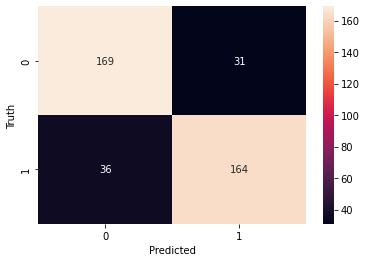

In [24]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [25]:
print(classification_report(y_test.deceptive, y_predicted))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       200
           1       0.84      0.82      0.83       200

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400

